<a href="https://colab.research.google.com/github/niraj8763/Deep-Learning/blob/master/Reconstructing_handwritten_digits_using_an_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  VanillaAutoencoder
## The code  will required  the Numpy, Tensorflow, Matplotlib Module

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameter Tuning
np.random.seed(11)
tf.random.set_seed(11)
batch_size  = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

We normalize the data so that pixel values lie between [0,1]; this is
achieved by simply dividing each pixel element by 255
then we reshape the tensors from 2D to 1D

In [ ]:
(X_train,_),(X_test,_) = k.datasets.mnist.load_data()
X_train = X_train/255
X_test = X_test/255
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train = np.reshape(X_train,(X_train.shape[0],784))
X_test = np.reshape(X_test,(X_test.shape[0],784))
training_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


# Encoder

In [ ]:
class Encoder(k.layers.Layer):
    def __init__(self,hidden_dim):
        super(Encoder,self).__init__()
        self.hidden_layer = k.layers.Dense(units=hidden_dim,activation=tf.nn.relu)
    
    def call(self,input_features):
        activation = self.hidden_layer(input_features)
        return activation

# Decoder

In [ ]:
class Decoder(k.layers.Layer):
    def __init__(self,hidden_dim,original_dim):
        super(Decoder,self).__init__()
        self.output_layer = k.layers.Dense(units=original_dim,activation=tf.nn.relu)
    
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

# Autoenocoder

In [ ]:
class Autoencoder(k.Model):
    def __init__(self,hidden_dim,original_dim):
        super(Autoencoder,self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim = hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim,original_dim=original_dim)
    
    def call(self,input_features):
        encoded = self.encoder(input_features)
        reconstructed =self.decoder(encoded)
        return reconstructed
        

Now we instantiate our autoencoder model object and define the loss and optimizers
to be used for training

In [ ]:
autoencoder = Autoencoder(hidden_dim = hidden_dim,original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
def loss(preds,real):
    return tf.reduce_mean(tf.square(tf.subtract(preds,real)))

Instead of using the auto-training loop, for our custom autoencoder model we will
define a custom training. We use tf.GradientTape to record the gradients as they
are calculated and implicitly apply the gradients to all the trainable variables of
our model

In [ ]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
    return reconstruction_error

In [ ]:
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [ ]:
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 4.824968338012695
Epoch 2/50. Loss: 2.936595916748047
Epoch 3/50. Loss: 2.817255735397339
Epoch 4/50. Loss: 2.8035571575164795
Epoch 5/50. Loss: 2.786447048187256
Epoch 6/50. Loss: 2.7395381927490234
Epoch 7/50. Loss: 2.7305212020874023
Epoch 8/50. Loss: 2.7181499004364014
Epoch 9/50. Loss: 2.7110395431518555
Epoch 10/50. Loss: 2.71226167678833
Epoch 11/50. Loss: 2.6913347244262695
Epoch 12/50. Loss: 2.69667649269104
Epoch 13/50. Loss: 2.6892459392547607
Epoch 14/50. Loss: 2.7182328701019287
Epoch 15/50. Loss: 2.6995174884796143
Epoch 16/50. Loss: 2.694401502609253
Epoch 17/50. Loss: 2.690089225769043
Epoch 18/50. Loss: 2.717951774597168
Epoch 19/50. Loss: 2.698357105255127
Epoch 20/50. Loss: 2.711487054824829
Epoch 21/50. Loss: 2.6884233951568604
Epoch 22/50. Loss: 2.6892600059509277
Epoch 23/50. Loss: 2.687645673751831
Epoch 24/50. Loss: 2.7159786224365234
Epoch 25/50. Loss: 2.671239137649536
Epoch 26/50. Loss: 2.6984610557556152
Epoch 27/50. Loss: 2.67547869682312


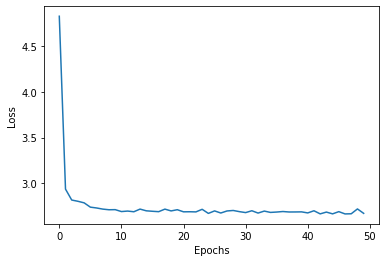

In [ ]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

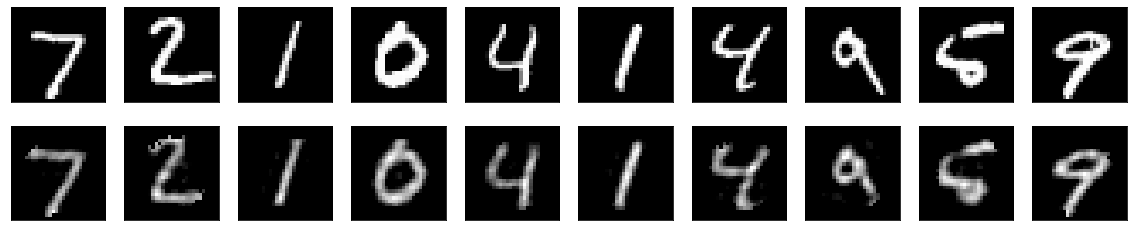

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(X_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()